# Thermodynamic correction factors

The thermodynamic correction factor is an important property when considering diffusion problems. This is an example for the calculation of a thermodynamic correction factor for calculating Stefan-Maxwell diffusion coefficients from Fickian diffusion coefficients. PC-SAFT calculation for the thermodynamic factor of water in a water-indomethacin mixture were performed (see the example in Table 2 from https://doi.org/10.1021/acs.molpharmaceut.1c00984).
Furthermore, this book explains statements which can be made from its values.

In [76]:
import numpy as np
from epcsaftpy import component, KBI, TH, pcsaft
from sgtpy.equilibrium import lle
import matplotlib.pyplot as plt

We define the PC-SAFT parameters and binary interaction parameters.

In [77]:
Water = component('Water', ms = 1.2046817736, sigma = [2.7927, 10.11, -0.01775, -1.417, -0.01146], eps = 353.9449,
                 kappaAB = 0.045090, eAB = 2425.6714, sites = [0, 1, 1], Mw = 18.01528)
IND = component('indomethacin', ms = 357.79*0.03992, sigma = 3.535 , eps = 262.791, 
               kappaAB = 0.02, eAB = 886.44, sites = [0, 3, 3], Mw = 357.79)
mix = Water + IND
mix.set_kijsaft(i = 0, j = 1, kij0 = -0.022)
saft = pcsaft(mix, compute_critical = False)

We define the temperature, pressure and a range of mass fractions.

In [78]:
T = 298.15 # K
P = 1E5 # Pa
npoint=100
w1=np.linspace(0.0001,0.9999,npoint)
n1=w1/saft.Mw[0]
w2=1-w1
n2=w2/saft.Mw[1]
x1=n1/(n1+n2)
x2=1-x1
z1=np.stack((x1,x2))

Formally the thermodynamic factor represents the slope of the reduced chemical potential of a component with respective to the same/another component's mole fraction:

$\Gamma_{ij} = (\frac{\partial \mu_{i}}{\partial ln x_{j}})_{T,P,x_{i\neq j}}$

,where the differentiation considers the mass balance i.e $\Sigma^{n_{c}}_{i}x_{i}=1$ of all $n_{c}$ components. The thermodynamic factor can be simply calculated via:


In [79]:
THij=TH(z1[:,0],T,P,saft)

Which is a scalar in a binary system...
We perform the same operations as described in  https://doi.org/10.1021/acs.molpharmaceut.1c00984 to calculate the Stefan-Maxwell diffusion coefficients displayed in Table 2.


In [80]:
THw=np.asarray([TH(z1[:,i],T,P,saft) for i in range(npoint)])
Dw=np.asarray([39.6,17.8,19.7,45.2,86.7,101.0])*1E-15
ww=np.asarray([0,0.088,0.387,0.704,1.13,1.64,2.43])/100
wave=ww[1:]*0.7+ww[:-1]*0.3
Ðw=Dw/np.interp(wave,w1,THw)
print(Ðw)

[3.98438226e-14 1.83072289e-14 2.08740606e-14 4.97943269e-14
 9.82706089e-14 1.19128302e-13]


Generally, the thermodynamic factor $\Gamma$ is a matrix with row and column size of $n_{c}-1$, so one row and one column was eliminated . This is because of the mass balance which would result in a singularity of a $n_{c}$-sized quadratic matrix. 

This should not be confused with the matrix derivative of the reduced chemical potential $\mu_{i}$ towards the mole fraction:

$\hat{\mu}_{ij} = (\frac{D \mu_{i}}{D ln x_{j}})_{T,P,x_{i\neq j}}$

The differentiation denoted by $\frac{D}{Dln x_{i}}$ does not consider the mass balance


In [81]:
rho=saft.density(z1[:,0],T,P, "L")
res=KBI(z1[:,0], T, P, saft, full_output = True)
muij=res["muij"]

As a result, a quadratic $n_{c}$-sized matrix is constructed

$\hat{\mu} =$ 
$\left[\begin{array}{rrr} 
\hat{\mu}_{11} & \hat{\mu}_{21} \\ 
\hat{\mu}_{12} & \hat{\mu}_{22} \\
\end{array}\right]$


and is this was actually used to construct thermodynamic factor matrix $\Gamma$. 

For the binary system is $\Gamma= \hat{\mu}_{11}-\hat{\mu}_{12}=\hat{\mu}_{22}-\hat{\mu}_{21}$ . Which is easily verified by:

In [82]:
print(THij-(muij[0,0]-muij[0,1]))
print(THij-(muij[1,1]-muij[1,0]))

0.0
-3.3306690738754696e-16


The thermodynamic factor is also connected to the Kirkwood-Buff-Integral (KBI) matrix denoted as $G_{ij}$ . For a binary system  $\Gamma_{11}= 1-\frac{\rho x_{1} x_{2} \Delta_{11}}{1+\rho x_{1} x_{2} \Delta_{11}}$ with $\Delta_{11}= G_{11}+G_{12}-G_{21}-G_{11}$

In [83]:
Gij=res["Gij"]
delij=Gij[0,0]+Gij[1,1]-Gij[0,1]-Gij[1,0]
density=saft.density(z1[:,0],T,P, "L")
THG11=1-(x1[0]*x2[0]*density*delij)/(1+x1[0]*x2[0]*density*delij)
print(THij-THG11)

2.220446049250313e-16


Finally, the thermodynamic factor can be also used as a phase-stability criterion. This means that the roots of the determinant of $\Gamma$ are the spinodal of a miscibility gap.
We can calculate the miscibility gap for the water-indomethacin system using these roots as excellent starting values

In [84]:
THij=np.asarray([TH(z1[:,i],T,P,saft) for i in range(npoint)])
idx_r1=np.argmin(np.abs(THij))
idx_r2=np.argmin(np.abs(THij[idx_r1+1:]))+idx_r1+1

x0=z1[:,idx_r1]
y0=z1[:,idx_r2]


sol = lle(x0,y0,(x0+y0)/2,T,P,saft)
xL11,xL21,_=sol
wL11=xL11*saft.Mw/(xL11*saft.Mw).sum()
wL21=xL21*saft.Mw/(xL21*saft.Mw).sum()
w0=x0*saft.Mw/(x0*saft.Mw).sum()
v0=y0*saft.Mw/(y0*saft.Mw).sum()

print(x0)
print(y0)

[0.78014325 0.21985675]
[0.99895788 0.00104212]


and finally plot the results. The orange lines are the thermodynamic factor and the red-dashed lines mark their roots which are the spinodal points. The black dashed line mark the miscibility gap.

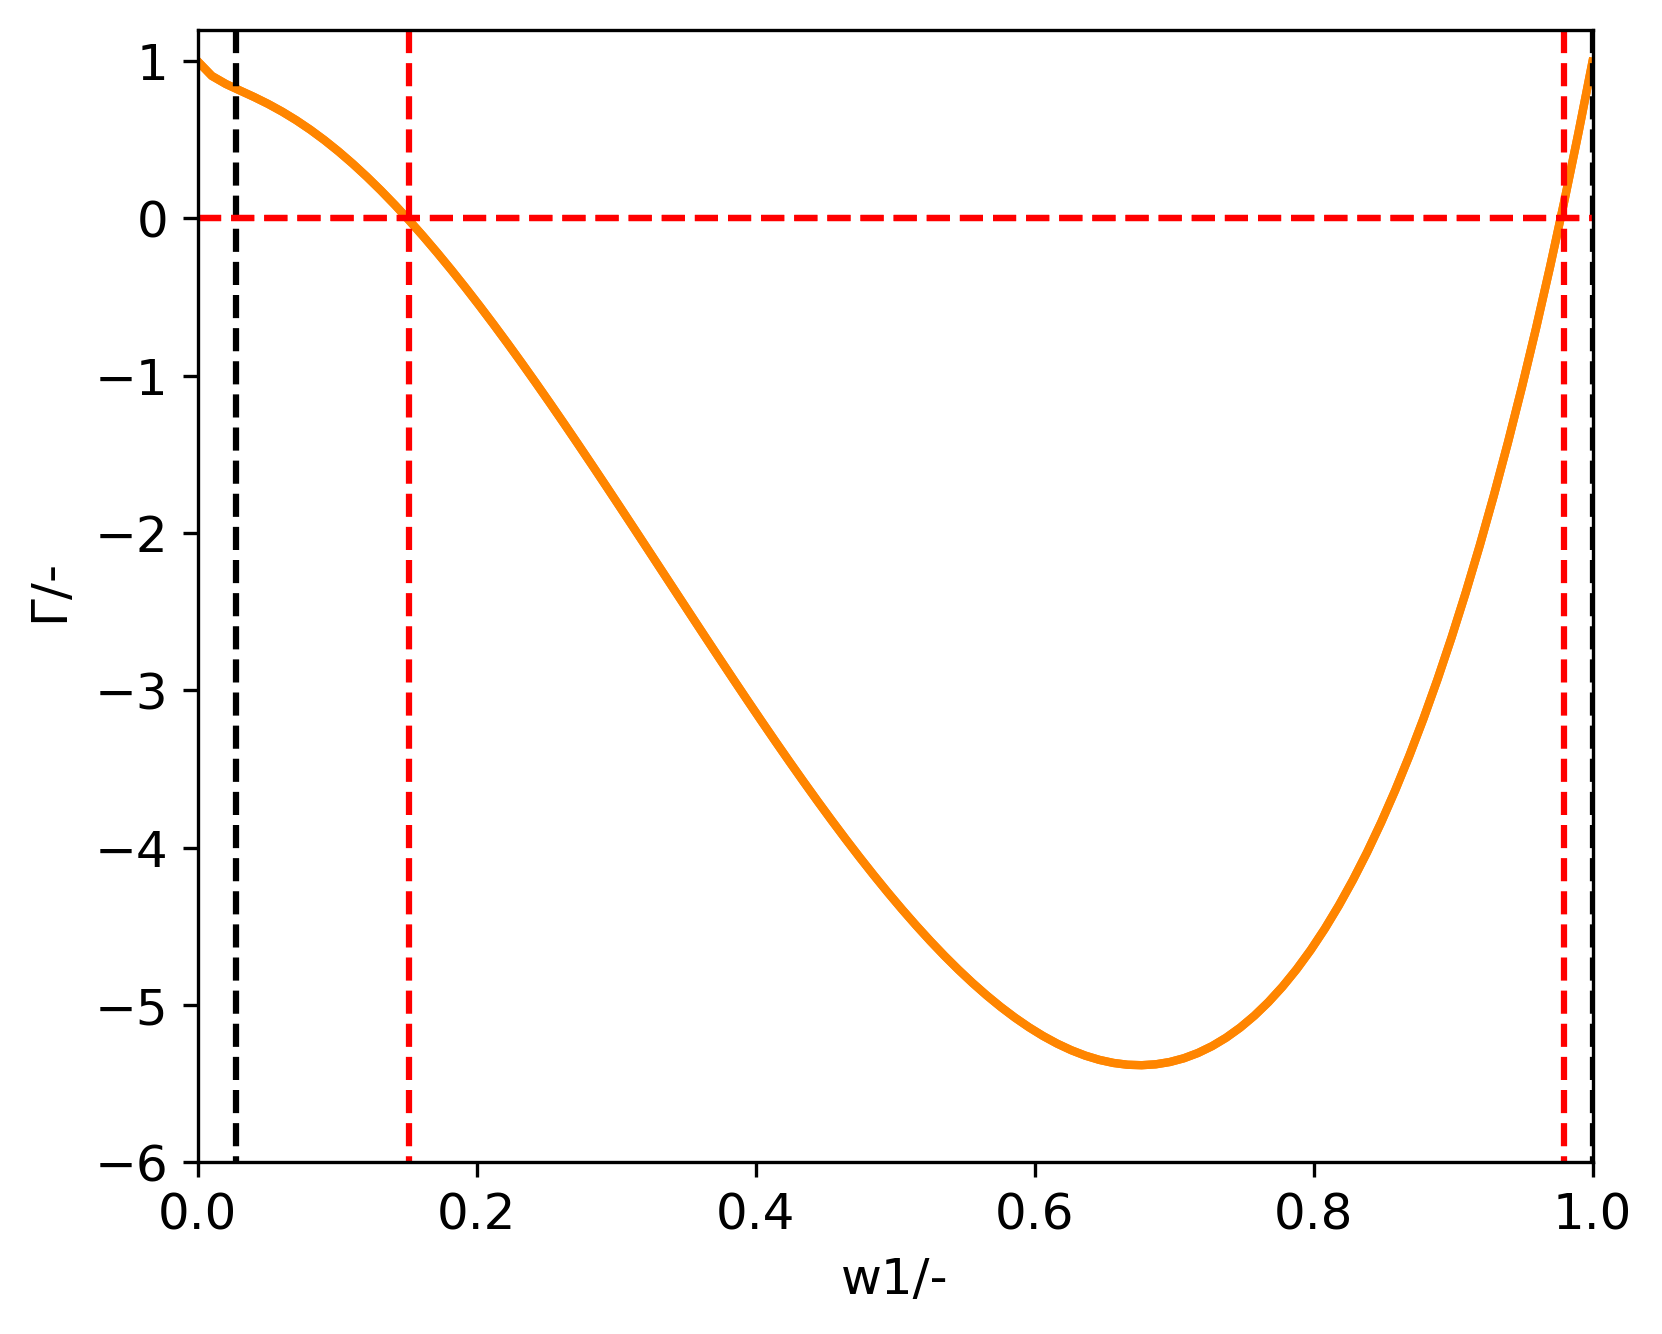

In [85]:
font = {'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

colorLLE = "#FF8500"

fig, ax = plt.subplots(figsize = (6, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)


ax.plot(w1,THij, "-",color = colorLLE , 
        linewidth = 2.0, label = "THFaktor")
ax.set_ylim([-6,1.2])
ax.set_xlim([0,1])
ax.set_xlabel("w1/-")
ax.set_ylabel("$\Gamma$/-")

ax.plot(w1,THij, "-",color = colorLLE , 
        linewidth = 2.0, label = "THFaktor")
ax.plot([wL11[0],wL11[0]],[1.2,-6],"k--")
ax.plot([wL21[0],wL21[0]],[1.2,-6],"k--")
ax.plot([w0[0],w0[0]],[1.2,-6],"r--")
ax.plot([v0[0],v0[0]],[1.2,-6],"r--")
ax.plot([0,1],[0,0],"r--")
ax.plot([0,1],[0,0],"r--")